In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# create a unique ID
grid['grid_idx'] = grid['Fire_ID'].astype(str) + grid['grid_index'].astype(str)

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y  # Latitude
grid = grid.merge(df[['grid_idx','x','y']], on='grid_idx', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any duplicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_idx','Fire_ID']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_idx','Fire_ID'], keep='first')


There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_idx', 'x', 'y'],
      dtype='object')

Dropping [0] duplicate grids.



Fractional overlap:
count    57232.000000
mean         2.023404
std          2.001402
min          0.000003
25%          0.587511
50%          1.493563
75%          2.771206
max         24.470760
Name: overlap, dtype: float64



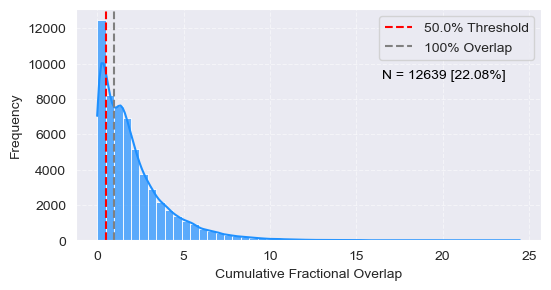

Plot saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/grid_overlap_distribution.png

Dropping [12639 (22.08%)] grids with <50.0% fractional overlap.
44593


In [3]:
# Check out the distribution of grid overlap with FRP observations
thresh = 0.50
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < thresh]['grid_idx'].count() 

# Plot the distribution of the fractional overlap
plt.figure(figsize=(6,3))
sns.histplot(grid['overlap'], kde=True, bins=50, color='dodgerblue', alpha=0.7)

# Add vertical line for the threshold and for 100%
plt.axvline(x=thresh, color='red', linestyle='--', label=f'{thresh*100}% Threshold')
plt.axvline(x=1, color='grey', linestyle='--', label='100% Overlap')

# Customize the plot
plt.xlabel('Cumulative Fractional Overlap')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.text(16.5, plt.ylim()[1] * 0.7, 
         f'N = {n_small} [{round(n_small/len(grid)*100,2)}%]', 
         fontsize=10, color='black')

# Save the plot
out_path = os.path.join(projdir, 'figures/grid_overlap_distribution.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Plot saved to: {out_path}")

# filter out grids below the overlap threshold
print(f"\nDropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with <{thresh*100}% fractional overlap.")
grid = grid[grid['overlap'] >= thresh] # remove these observations
print(len(grid))

## Gather LANDFIRE variables for the study region

LANDFIRE ca. 2016; [EVT, CC, CH, CBD, CBH, ]

In [4]:
fuel_vars = {
    'CC': 'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF200/US_200CC_19/ImageServer',
    'CH': 'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF200/US_200CH_19/ImageServer',
    'CBD': 'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF200/US_200CBD_19/ImageServer',
    'CBH': 'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF200/US_200CBH_19/ImageServer'
}

# reproject the grid and get the bounds
grid_wgs = grid.to_crs('EPSG:4326')

# grab the EVT raster to use for zones
evt_url = 'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF200/US_200EVT/ImageServer'
print(f"Downloading the EVT raster from: {evt_url}")
evt_da = get_image_service_array(evt_url, grid_wgs, out_prefix='EVT')

# crop to gridcells
# match the CRS
grid_prj = grid.to_crs(evt_da.rio.crs)
# create the crop extent
bbox = box(*grid_prj.total_bounds) # make a bounding box
bbox = gpd.GeoDataFrame(geometry=[bbox], crs='EPSG:5070')
evt_da = evt_da.rio.clip(bbox.geometry) # do the crop

# get a list of EVT values
evt_arr = evt_da.values
evt_nodata = evt_da.rio.nodata
evt_vals = np.unique(evt_arr)
evt_vals = evt_vals[~np.isnan(evt_vals) & (evt_vals != evt_nodata)]
print(f"Found [{len(evt_vals)}] EVT codes")
del evt_nodata, evt_arr

Found [144] EVT codes


In [11]:
# identify EVT codes of interest
# first, download the data dictionary
dd = list_files(os.getcwd(),'*EVT.csv',recursive=True)[0]
print(dd)
if not dd:
    print("Downloading data dictionary")
    dd = download_lf_csv('EVT')
else:
    dd = pd.read_csv(dd)
# merge with the codes
evt_vals_df = pd.DataFrame({'EVT': evt_vals.astype(int)})
evt_df = evt_vals_df.merge(dd, left_on='EVT', right_on='VALUE')
evt_df

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/code/Python/lf_attributes/LF2024_EVT.csv


,EVT,VALUE,EVT_NAME,LFRDB,EVT_FUEL,EVT_FUEL_N,EVT_LF,EVT_PHYS,EVT_GP,EVT_GP_N,SAF_SRM,EVT_ORDER,EVT_CLASS,EVT_SBCLS,R,G,B,RED,GREEN,BLUE
0,7011,7011,Rocky Mountain Aspen Forest and Woodland,7011,2011,Tr Rocky Mountain Aspen Forest and Woodland,Tree,Hardwood,602,"Aspen Forest, Woodland, and Parkland",SAF 217: Aspen,Tree-dominated,Open tree canopy,Deciduous open tree canopy,192,255,138,0.752941,1.000000,0.541176
1,7012,7012,Rocky Mountain Bigtooth Maple Ravine Woodland,7012,2012,Tr Rocky Mountain Bigtooth Maple Ravine Woodland,Tree,Hardwood,605,Bigtooth Maple Woodland,SRM 418: Bigtooth Maple,Tree-dominated,Open tree canopy,Deciduous open tree canopy,171,255,138,0.670588,1.000000,0.541176
2,7016,7016,Colorado Plateau Pinyon-Juniper Woodland,7016,2016,Tr Colorado Plateau Pinyon-Juniper Woodland,Tree,Conifer,630,Pinyon-Juniper Woodland,SRM 504: Juniper-Pinyon Pine Woodland,Tree-dominated,Open tree canopy,Evergreen open tree canopy,121,255,94,0.474510,1.000000,0.368627
3,7020,7020,Inter-Mountain Basins Subalpine Limber-Bristle...,7020,2020,Tr Inter-Mountain Basins Subalpine Limber-Bris...,Tree,Conifer,621,Limber Pine Woodland,SAF 209: Bristlecone Pine,Tree-dominated,Open tree canopy,Evergreen open tree canopy,63,255,46,0.247059,1.000000,0.180392
4,7049,7049,Rocky Mountain Foothill Limber Pine-Juniper Wo...,7049,2049,Tr Rocky Mountain Foothill Limber Pine-Juniper...,Tree,Conifer,621,Limber Pine Woodland,SAF 219: Limber Pine,Tree-dominated,Open tree canopy,Evergreen open tree canopy,174,245,224,0.682353,0.960784,0.878431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,9816,9816,Northern & Central Plains Ruderal & Planted Gr...,9316,2567,Sh Northern & Central Plains Ruderal & Planted...,Herb,Exotic Herbaceous,703,Introduced Perennial Grassland and Forbland,LF 54: Introduced Upland Vegetation - Herbaceous,Herbaceous / Nonvascular-dominated,Herbaceous - grassland,Perennial graminoid grassland,255,105,46,1.000000,0.411765,0.180392
133,9825,9825,Great Plains Comanchian Ruderal Grassland,9325,2561,Sh Great Plains Comanchian Ruderal Grassland &...,Herb,Exotic Herbaceous,703,Introduced Perennial Grassland and Forbland,LF 54: Introduced Upland Vegetation - Herbaceous,Herbaceous / Nonvascular-dominated,Herbaceous - grassland,Perennial graminoid grassland,255,105,46,1.000000,0.411765,0.180392
134,9827,9827,Interior West Ruderal Riparian Scrub,9327,2278,Tr Interior West Ruderal Riparian Forest & Scrub,Shrub,Riparian,701,Introduced Riparian Vegetation,LF 58: Introduced Woody Wetlands and Riparian ...,Shrub-dominated,Shrubland,Mixed evergreen-deciduous shrubland,255,105,46,1.000000,0.411765,0.180392
135,9828,9828,Interior Western North American Temperate Rude...,9328,2279,Sh Interior Western North American Temperate R...,Herb,Exotic Herbaceous,703,Introduced Perennial Grassland and Forbland,LF 54: Introduced Upland Vegetation - Herbaceous,Herbaceous / Nonvascular-dominated,Herbaceous - grassland,Perennial graminoid grassland,255,105,46,1.000000,0.411765,0.180392


In [12]:
evt_df.columns

Index(['EVT', 'VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')

In [13]:
evt_df['EVT_SBCLS'].unique()

array(['Deciduous open tree canopy', 'Evergreen open tree canopy',
       'Evergreen closed tree canopy',
       'Mixed evergreen-deciduous open tree canopy',
       'Evergreen dwarf-shrubland', 'Mixed evergreen-deciduous shrubland',
       'Evergreen shrubland', 'Evergreen sparse tree canopy',
       'Perennial graminoid grassland', 'Perennial graminoid',
       'Non-vegetated', 'Developed', 'Annual Graminoid/Forb',
       'Sparsely vegetated', 'Deciduous shrubland'], dtype=object)

In [15]:
# filter to forested EVTs, look at the SAF code
trees_shrubs = ['Deciduous open tree canopy', 'Evergreen open tree canopy',
                'Evergreen closed tree canopy', 'Mixed evergreen-deciduous open tree canopy',
                'Evergreen sparse tree canopy']
evt_df_tree = evt_df[evt_df['EVT_SBCLS'].isin(trees_shrubs)]
evt_df_tree['SAF_SRM'].unique()

array(['SAF 217: Aspen', 'SRM 418: Bigtooth Maple',
       'SRM 504: Juniper-Pinyon Pine Woodland',
       'SAF 209: Bristlecone Pine', 'SAF 219: Limber Pine',
       'SAF 218: Lodgepole Pine', 'SAF 210: Interior Douglas-Fir',
       'SAF 211: White Fir', 'SAF 237: Interior Ponderosa Pine',
       'SAF 206: Engelmann Spruce-Subalpine Fir',
       'SRM 415: Curlleaf Mountain-Mahogany',
       'SRM 412: Juniper-Pinyon Woodland',
       'LF 64: Recently Logged - Tree', 'LF 68: Recently Burned - Tree',
       'LF 100: Recently Disturbed Other - Tree',
       'LF 41: Deciduous Shrubland', 'LF 20: Developed',
       'LF 80: Agriculture', 'SAF 235: Cottonwood-Willow',
       'SRM 422: Riparian', 'LF 42: Great Plains Riparian',
       'LF 58: Introduced Woody Wetlands and Riparian Vegetation'],
      dtype=object)

In [16]:
# filter to species of interest using the SAF code
saf_keep = [
    'SAF 217: Aspen',
    'SRM 504: Juniper-Pinyon Pine Woodland',
    'SAF 218: Lodgepole Pine',
    'SAF 210: Interior Douglas-Fir',
    'SAF 211: White Fir',
    'SAF 237: Interior Ponderosa Pine',
    'SAF 206: Engelmann Spruce-Subalpine Fir',
    'LF 41: Deciduous Shrubland'
]

# gather new set of EVT codes:
evt_df_tree_evt = evt_df_tree[evt_df_tree['SAF_SRM'].isin(saf_keep)]
print(f"Filtered to [{len(evt_df_tree_evt['EVT'].unique())}] EVT codes")

Filtered to [14] EVT codes


In [17]:
# get the fuels arrays
print("\nAccessing fuel rasters")

fuel_arrs = {} # to store the results
for var, url in fuel_vars.items():
    print(f"\nDownloading [{var}] raster from: {url}")
    # get the raster
    da = get_image_service_array(url, grid_wgs, out_prefix=var)
    # crop it using the bounding box we created earlier
    da = da.rio.clip(bbox.geometry) # crop to the extent bounds
    # add to the results dictionary
    fuel_arrs[var] = da
    del da

print("\nFuel rasters successfully processed")


Accessing fuel rasters





Fuel rasters successfully processed


### Gather the USFS TreeMap bands (ca. 2016)

BALIVE, SDI, and QMD

In [18]:
# load the TreeMap rasters (locally stored)
tm_paths = {
    'BALIVE': list_files(os.path.join(maindir, 'data/landcover/USFS/RDS_TreeMap/'), ext='*_BALIVE.tif', recursive=True)[0],
    'SDI': list_files(os.path.join(maindir, 'data/landcover/USFS/RDS_TreeMap/'), ext='*SDI*.tif', recursive=True)[0],
    'QMD': list_files(os.path.join(maindir, 'data/landcover/USFS/RDS_TreeMap/'), ext='*QMD*.tif', recursive=True)[0]
}
print(tm_paths, "\n")

# store the cropped arrays
tm_arrs = {}
ref = next(iter(fuel_arrs.values()))  # reference raster
for tm, fp in tm_paths.items():
    print(f"\nProcessing [{tm}]")
    # open the raster files
    with rio.open(fp) as src:
        bounds = grid.to_crs(src.crs).total_bounds
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)

        # Build spatial coordinates
        transform = src.window_transform(window)
        height, width = data.shape
        x_coords = np.arange(width) * transform.a + transform.c + transform.a / 2
        y_coords = np.arange(height) * transform.e + transform.f + transform.e / 2

        da = xr.DataArray(
            data,
            dims=("y", "x"),
            coords={"y": y_coords, "x": x_coords},
            name=tm
        )
        da.rio.write_crs(src.crs, inplace=True)
        da.rio.write_transform(transform, inplace=True)

        # reproject to match the reference
        da_prj = da.rio.reproject_match(ref)

        tm_arrs[tm] = da_prj # add to the array dictionary
        del da, da_prj

print("\nProcessing TreeMap layers complete.")

{'BALIVE': '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/data/landcover/USFS/RDS_TreeMap/TreeMap2016_BALIVE/TreeMap2016_BALIVE.tif', 'SDI': '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/data/landcover/USFS/RDS_TreeMap/TreeMap2016_SDIPCT_RMRS/TreeMap2016_SDIPCT_RMRS.tif', 'QMD': '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/data/landcover/USFS/RDS_TreeMap/TreeMap2016_QMD_RMRS/TreeMap2016_QMD_RMRS.tif'} 


Processing [BALIVE]

Processing [SDI]

Processing [QMD]

Processing TreeMap layers complete.


### Create the data stack and convert to dataframe summary

Stack the EVT and fuels arrays, the TreeMap bands, and a rasterized 'grid_idx' into one multiband array. Then, convert to a data frame and calculate the EVT-specific fuel conditions for each 'grid_idx'.

In [19]:
# create a raster grid for grid_idx to use as zones
# convert grid_idx to numeric
grid_prj['grid_idx'] = pd.to_numeric(grid_prj['grid_idx'], errors='coerce')
grid_idx_da = rasterize_grid_idx(grid_prj, ref_da=evt_da)
print("Created the 'grid_idx' raster")
print(f"Output shape: {grid_idx_da.shape}")
print(f"Reference image shape: {evt_da.shape}")

Created the 'grid_idx' raster
Output shape: (25500, 14162)
Reference image shape: (25500, 14162)


In [20]:
# stack the bands
da_stack = xr.Dataset({
    var: da
    for var, da in fuel_arrs.items()
})

# add the EVT, TreeMap and grid_idx
da_stack['EVT'] = evt_da
da_stack['BALIVE'] = tm_arrs['BALIVE']
da_stack['SDI'] = tm_arrs['SDI']
da_stack['QMD'] = tm_arrs['QMD']
da_stack['grid_idx'] = grid_idx_da

da_stack

<xarray.Dataset> Size: 13GB
Dimensions:      (x: 14162, y: 25500)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 113kB -1.179e+06 -1.179e+06 ... -7.538e+05
  * y            (y) float64 204kB 2.192e+06 2.192e+06 ... 1.427e+06 1.427e+06
    spatial_ref  int64 8B 0
Data variables:
    CC           (y, x) float32 1GB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CH           (y, x) float32 1GB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CBD          (y, x) float32 1GB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CBH          (y, x) float32 1GB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    EVT          (y, x) float32 1GB 7.08e+03 7.08e+03 ... 7.149e+03 7.149e+03
    BALIVE       (y, x) float32 1GB 3.403e+38 3.403e+38 ... 3.403e+38 3.403e+38
    SDI          (y, x) float32 1GB 3.403e+38 3.403e+38 ... 3.403e+38 3.403e+38
    QMD          (y, x) float32 1GB 3.403e+38 3.403e+38 ... 3.403e+38 3.403e+38
    grid_idx     (y, x) uint32 1GB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [21]:
# gather the dataframe
df = da_stack.to_dataframe().reset_index()
df = df.dropna(subset=['EVT']) # keep valid rows
df = df[df['grid_idx'] != 0] # filter where grid_idx != 0 (background)
# filter to EVT codes of interest
df = df[df['EVT'].isin(evt_df_tree_evt['EVT'].unique())]
df['EVT'] = df['EVT'].astype(int) # force EVT code to integer

# group and summarize by grid_idx
df = df.groupby(['grid_idx','EVT']).agg({
    'CC': 'mean',
    'CH': 'mean',
    'CBH': 'mean',
    'CBD': 'mean',
    'BALIVE': 'mean',
    'SDI': 'mean',
    'QMD': 'mean'
}).reset_index()
df.head()

,grid_idx,EVT,CC,CH,CBH,CBD,BALIVE,SDI,QMD
0,819725,7011,35.000000,144.000000,93.925003,1.00,47.054203,16.542500,6.035000
1,819725,7051,35.000000,110.000000,3.000000,8.00,61.333351,inf,inf
2,819725,7055,52.500000,150.000000,5.500000,11.75,141.676605,41.950001,5.275000
3,819725,7061,45.500000,176.000000,3.000000,9.20,98.226616,34.849998,6.800000
4,821970,7011,47.950821,151.311478,100.000000,1.00,78.202248,23.178688,6.440983


In [22]:
# join the EVT names
dd_ = dd[['VALUE','SAF_SRM']]
grid_evt = df.merge(dd_, left_on='EVT', right_on='VALUE')
grid_evt

,grid_idx,EVT,CC,CH,CBH,CBD,BALIVE,SDI,QMD,VALUE,SAF_SRM
0,819725,7011,35.000000,144.000000,93.925003,1.000000,47.054203,16.542500,6.035000,7011,SAF 217: Aspen
1,819725,7051,35.000000,110.000000,3.000000,8.000000,61.333351,inf,inf,7051,SAF 210: Interior Douglas-Fir
2,819725,7055,52.500000,150.000000,5.500000,11.750000,141.676605,41.950001,5.275000,7055,SAF 206: Engelmann Spruce-Subalpine Fir
3,819725,7061,45.500000,176.000000,3.000000,9.200000,98.226616,34.849998,6.800000,7061,SAF 217: Aspen
4,821970,7011,47.950821,151.311478,100.000000,1.000000,78.202248,23.178688,6.440983,7011,SAF 217: Aspen
...,...,...,...,...,...,...,...,...,...,...,...
138934,1421407314,7051,52.032967,164.505493,3.000000,11.384615,110.604256,NaN,NaN,7051,SAF 210: Interior Douglas-Fir
138935,1421407314,7052,52.500000,180.000000,4.625000,11.000000,184.819672,42.312500,8.537499,7052,SAF 211: White Fir
138936,1421407314,7054,40.000000,115.000000,3.500000,9.000000,87.436249,NaN,NaN,7054,SAF 237: Interior Ponderosa Pine
138937,1421407314,7055,54.000000,166.000000,6.000000,12.100000,116.422379,30.350000,6.220000,7055,SAF 206: Engelmann Spruce-Subalpine Fir


In [23]:
print(len(grid_evt))
print(grid_evt['SDI'].isna().sum())
grid_evt[grid_evt['SDI'].isna()]['SAF_SRM'].value_counts()

138939
57941


SAF_SRM
SAF 237: Interior Ponderosa Pine           17015
SAF 210: Interior Douglas-Fir              15785
SAF 211: White Fir                          8571
SAF 218: Lodgepole Pine                     7314
SAF 206: Engelmann Spruce-Subalpine Fir     4213
SAF 217: Aspen                              3398
SRM 504: Juniper-Pinyon Pine Woodland       1645
Name: count, dtype: int64

In [29]:
# manage the EVT values, reclassing
grid_evt['SAF_SRM'].unique()

array(['SAF 217: Aspen', 'SAF 210: Interior Douglas-Fir',
       'SAF 206: Engelmann Spruce-Subalpine Fir', 'SAF 211: White Fir',
       'SAF 237: Interior Ponderosa Pine',
       'SRM 504: Juniper-Pinyon Pine Woodland', 'SAF 218: Lodgepole Pine'],
      dtype=object)

In [34]:
# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies
spp_grouping = {
    'SAF 217: Aspen': 'Aspen',
    'SAF 206: Engelmann Spruce-Subalpine Fir': 'Spruce-fir',
    'SAF 237: Interior Ponderosa Pine': 'Ponderosa pine',
    'SAF 218: Lodgepole Pine': 'Lodgepole pine',
    'SAF 210: Interior Douglas-Fir': 'Douglas-fir',
    'SAF 211: White Fir': 'White fir',
    'SRM 504: Juniper-Pinyon Pine Woodland': 'Pinon-juniper',
}

# create the remap table
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = grid_evt[grid_evt['SAF_SRM'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update(
        {name: spp_group for name in spp['SAF_SRM'].unique()}
    )
    del spp

# Apply the remap to create a new grouped species column
grid_evt['fortypnm_gp'] = grid_evt['SAF_SRM'].map(spp_remap).fillna(grid_evt['SAF_SRM'])

# separate the aspen classes
# Override with EVT-based rule for Aspen separation
grid_evt.loc[grid_evt['EVT'] == 7011, 'fortypnm_gp'] = 'Aspen'
grid_evt.loc[grid_evt['EVT'] == 7061, 'fortypnm_gp'] = 'Aspen–Mixed'

# Verify the updated species groups
grid_evt[['grid_idx', 'SAF_SRM', 'fortypnm_gp']].drop_duplicates().head(8)

,grid_idx,SAF_SRM,fortypnm_gp
0,819725,SAF 217: Aspen,Aspen
1,819725,SAF 210: Interior Douglas-Fir,Douglas-fir
2,819725,SAF 206: Engelmann Spruce-Subalpine Fir,Spruce-fir
3,819725,SAF 217: Aspen,Aspen–Mixed
4,821970,SAF 217: Aspen,Aspen
5,821970,SAF 210: Interior Douglas-Fir,Douglas-fir
6,821970,SAF 206: Engelmann Spruce-Subalpine Fir,Spruce-fir
8,821970,SAF 217: Aspen,Aspen–Mixed


In [35]:
# calculate the EVT proportion per gridcell
zs_evt = compute_band_stats(grid_prj, evt_da, id_col='grid_idx', attr='EVT')
# tidy the data frame
zs_evt = zs_evt[['grid_idx', 'EVT', 'pct_cover']]
zs_evt.rename(columns={'pct_cover': 'proportion'}, inplace=True)
zs_evt

,grid_idx,EVT,proportion
0,161955422,7011,1.775148
1,161955422,7051,31.952663
2,161955422,7052,34.319527
3,161955422,7054,17.159763
4,161955422,7086,1.775148
...,...,...,...
251716,1111873731,7117,0.588235
251717,1111873731,7126,8.823529
251718,1111873731,7195,10.588235
251719,1111873731,9019,0.588235


In [36]:
# merge the EVT proportion
grid_evt_pr = grid_evt.merge(zs_evt, on=['grid_idx', 'EVT'])
grid_evt_pr

,grid_idx,EVT,CC,CH,CBH,CBD,BALIVE,SDI,QMD,VALUE,SAF_SRM,fortypnm_gp,proportion
0,819725,7011,35.000000,144.000000,93.925003,1.000000,47.054203,16.542500,6.035000,7011,SAF 217: Aspen,Aspen,24.117647
1,819725,7051,35.000000,110.000000,3.000000,8.000000,61.333351,inf,inf,7051,SAF 210: Interior Douglas-Fir,Douglas-fir,1.176471
2,819725,7055,52.500000,150.000000,5.500000,11.750000,141.676605,41.950001,5.275000,7055,SAF 206: Engelmann Spruce-Subalpine Fir,Spruce-fir,2.352941
3,819725,7061,45.500000,176.000000,3.000000,9.200000,98.226616,34.849998,6.800000,7061,SAF 217: Aspen,Aspen–Mixed,11.764706
4,821970,7011,47.950821,151.311478,100.000000,1.000000,78.202248,23.178688,6.440983,7011,SAF 217: Aspen,Aspen,39.644970
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138848,1421407314,7051,52.032967,164.505493,3.000000,11.384615,110.604256,NaN,NaN,7051,SAF 210: Interior Douglas-Fir,Douglas-fir,53.254438
138849,1421407314,7052,52.500000,180.000000,4.625000,11.000000,184.819672,42.312500,8.537499,7052,SAF 211: White Fir,White fir,4.733728
138850,1421407314,7054,40.000000,115.000000,3.500000,9.000000,87.436249,NaN,NaN,7054,SAF 237: Interior Ponderosa Pine,Ponderosa pine,4.733728
138851,1421407314,7055,54.000000,166.000000,6.000000,12.100000,116.422379,30.350000,6.220000,7055,SAF 206: Engelmann Spruce-Subalpine Fir,Spruce-fir,5.917160


In [37]:
# tidy some of the columns
grid_evt_pr = grid_evt_pr[['grid_idx', 'fortypnm_gp', 'CC', 'CH', 'CBH', 'CBD', 'BALIVE', 'SDI', 'QMD', 'proportion']]
# save this file out.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_lf.csv')
grid_evt_pr.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_lf.csv
